# Battle of the Neighbourhoods - New Cinema in the Nottinghamshire area

## Introduction

### Scenario:
I have been tasked by a client with finding a suitable location in the Nottinghamshire area for a new cinema to be built or for an existing building to be converted.  The Nottinghamshire area already has many cinema venues, so the location has to be carefully selected to ensure that it will be a successful business venture.  My client already has a chain of independent cinemas in the North of England and is looking for a new location in the Midlands, with Nottinghamshire being the preferred location. 
### The scope of this project within the wider business analysis:
Opening a new cinema requires significant capital investment.  Deciding on a location, whilst an important part of the strategic decision, is only one of many factors to be explored.  The local demographics of the area is an important factor to consider.  Other analysis such as SWOT and 5 Market forces should also be a starting point for decision making.  The barriers to entry for building a new cinema are high due to the upfront capital investment and the understanding of the business sector.  Streaming providers such as Netflix and Amazon Prime should be considered as a threat to the viability of existing and new entrants to the cinema market.  The high supply cost of showing new release Hollywood movies should be considered when deciding what type of cinema to build.  The projected revenues and costs should then be computed to determine the actual return on investment to ascertain whether the project is potentially viable.  Funding would then need to be sourced.  The scope of this project is to determine only which NG (Nottinghamshire) postcode is the most suitable location for a new cinema to be built.
### Types of cinemas:
The existing cinemas in Nottinghamshire are Multiplex cinemas such as Odeon and CineWorld, along with smaller chains such as the Savoy cinemas.  There is also a popular independent cinema, Broadway, in the centre of Nottinghamshire that specialises in classics and alternative films.  The type of cinema to be built would depend on the results of the business analysis.  Cinemas such as the Savoy or Broadway are much smaller than the Multiplex cinemas and will perhaps show only a couple of the main release films at one time, offering older films that are cheaper from a supply perspective on the other screens.  They offer a more intimate experience than the multiplex cinemas, with Broadway also having a bar and small restaurant.  Creating more of an experience is likely to be ever more important when competing for customers with Netflix and Amazon Prime.
### Methodology used:
#### NG Postal code data:
The Nottingham postal code data will be extracted from the webpage: https://en.wikipedia.org/wiki/NG_postcode_area’, using the function dfs=pd.read_html(url) to read the data into a pandas dataframe.  This will data will be used to select from when determining a suitable location for a new cinema. The extracted data will need to have coordinates found, so the postcode district and post town are combined into a full address column:
#### Converting the NG Postal code data into coordinates for mapping:
Using Geopy, the NG Postal code data will be used to find the approximate centre latitude and longitude coordinates of the postal codes.  These coordinates will be added to the dataframe.
#### Mapping the NG Postal codes
The postal codes will then be mapped using Folium to provide a visual of the distribution of the postal codes.
#### Obtaining existing Cinema venues around the Nottinghamshire area
Foursquare will be used to obtain existing cinema venues around the Nottinghamshire area.  This information will be stored in a dataframe, the data cleaned and the resulting location venues will be mapped onto the same map as the NG Postal codes.  This will provide an initial visual of postal areas that do not already have a nearby cinema venue.  It is better to identify a location that does not already have a cinema so that there is less competition for customers.
#### Clustering the NG Postal codes using popular venues
Foursquare will be used again to find the nearby 100 venues for each postal area.  The data is then grouped by postal code area and sorted into the top 10 venues within each postal code area.  A clustering method called KMeans will be applied to this data in order to cluster the postal code areas based on top local venues.  To find the optimal k for the algorithm, the Elbow method is used.  The information produced from this clustering exercise will provide an idea as to which postal code areas are similar types of Neighbourhoods based on nearby venues
#### Mapping the clusters on the same map and determining the best location
With each area assigned to a particular cluster and imposed on the map, this will then provide an additional visual of which clusters tend to have cinemas and help identify if there are any postal codes that fall in the same cluster but that do not have a nearby cinema.  Such a location could be a potentially good location for a new cinema
#### Limitations of the scope of this project
It is important to note again that proximity to existing cinemas and similarity of neighbourhoods based on popular venues are only a very small part of the overall picture when deciding where to build a new cinema in Nottinghamshire and that the results of this project should be used in conjunction with a vast array of other supporting material as discussed in the wider business analysis section


In [1]:
# Import the required libraries
# !pip install pandas
# !pip install requests
!pip install bs4
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
# Import Folium 
!conda install -c conda-forge folium=0.5.0
import folium 
!conda install -c conda-forge geopy 
from geopy.geocoders import Nominatim 

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1273 sha256=6c3319b3db49c74a1c15a86b1c5db77d52a2f5709aeeb0bd17607002ed0c006e
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/0a/9e/ba/20e5bbc1afef3a491f0b3bb74d508f99403aabe76eda2167ca
Successfully built bs4
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python-3.7-OpenCE

  added / updated specs:
    - folium=0.5.0


The following packages will be

In [2]:
# Obtain the Nottingham postcode data from the webpage and convert into a dataframe
url = 'https://en.wikipedia.org/wiki/NG_postcode_area'
dfs = pd.read_html(url)
df = dfs[1]
df.head()

,Postcode district,Post town,Coverage,Local authority area(s)
0,NG1,NOTTINGHAM,Nottingham city centre,Nottingham
1,NG2,NOTTINGHAM,"Nottingham city centre, Colwick Park, Sneinton...","Nottingham, Rushcliffe"
2,NG3,NOTTINGHAM,"Carlton, Sneinton, St Ann's, Mapperley","Gedling, Nottingham"
3,NG4,NOTTINGHAM,"Gedling Village, Netherfield, Carlton, Colwick",Gedling
4,NG5,NOTTINGHAM,"Sherwood, Arnold, Bestwood, Carrington, Top Va...","Nottingham, Gedling"


In [3]:
# Find type of objects 
print(df.dtypes)

Postcode district          object
Post town                  object
Coverage                   object
Local authority area(s)    object
dtype: object


In [4]:
# Convert to string and join the postcode and town to create the full address
df['Full address'] = df['Postcode district'].astype(str) + ',' + df['Post town'].astype(str)
df.head()

,Postcode district,Post town,Coverage,Local authority area(s),Full address
0,NG1,NOTTINGHAM,Nottingham city centre,Nottingham,"NG1,NOTTINGHAM"
1,NG2,NOTTINGHAM,"Nottingham city centre, Colwick Park, Sneinton...","Nottingham, Rushcliffe","NG2,NOTTINGHAM"
2,NG3,NOTTINGHAM,"Carlton, Sneinton, St Ann's, Mapperley","Gedling, Nottingham","NG3,NOTTINGHAM"
3,NG4,NOTTINGHAM,"Gedling Village, Netherfield, Carlton, Colwick",Gedling,"NG4,NOTTINGHAM"
4,NG5,NOTTINGHAM,"Sherwood, Arnold, Bestwood, Carrington, Top Va...","Nottingham, Gedling","NG5,NOTTINGHAM"


In [5]:
# Clean the data
# Drop the last 3 rows as they aren't genuine area postcodes and row 16 as it's a duplicate of NG17
df=df.drop([30,31,32,16])
df

,Postcode district,Post town,Coverage,Local authority area(s),Full address
0,NG1,NOTTINGHAM,Nottingham city centre,Nottingham,"NG1,NOTTINGHAM"
1,NG2,NOTTINGHAM,"Nottingham city centre, Colwick Park, Sneinton...","Nottingham, Rushcliffe","NG2,NOTTINGHAM"
2,NG3,NOTTINGHAM,"Carlton, Sneinton, St Ann's, Mapperley","Gedling, Nottingham","NG3,NOTTINGHAM"
3,NG4,NOTTINGHAM,"Gedling Village, Netherfield, Carlton, Colwick",Gedling,"NG4,NOTTINGHAM"
4,NG5,NOTTINGHAM,"Sherwood, Arnold, Bestwood, Carrington, Top Va...","Nottingham, Gedling","NG5,NOTTINGHAM"
5,NG6,NOTTINGHAM,"Bestwood Village, Bulwell, Old Basford","Nottingham, Gedling","NG6,NOTTINGHAM"
6,NG7,NOTTINGHAM,"New Basford, Forest Fields, Hyson Green, Radfo...",Nottingham,"NG7,NOTTINGHAM"
7,NG8,NOTTINGHAM,"Aspley, Wollaton, Whitemoor, Bilborough, Strelley","Nottingham, Broxtowe","NG8,NOTTINGHAM"
8,NG9,NOTTINGHAM,"Beeston, Stapleford, Lenton Abbey, Chilwell, T...","Broxtowe, Nottingham","NG9,NOTTINGHAM"
9,NG10,NOTTINGHAM,"Long Eaton, Sawley, Sandiacre",Erewash,"NG10,NOTTINGHAM"


In [7]:
# Find the Coordinates for the Full address using Geopy without exceptions and save in separate columns
from geopy.exc import GeocoderTimedOut
   
# Set up lists for Latitude and Longitude data to be stored
longitude = []
latitude = []
   
# Create function to find the coordinate
def findGeocode(Full_address):
       
# Use try and catch to overcome the exception thrown by geolocator using geocodertimedout  
    try:          
        geolocator = Nominatim(user_agent="myGeolocator")
          
        return geolocator.geocode(Full_address)
      
    except GeocoderTimedOut:
          
        return findGeocode(Full_address)    

# Each value from Coordinates column will be fetched and sent to function find_geocode   

for i in (df["Full address"]):
      
    if findGeocode(i) != None:
           
        loc = findGeocode(i)
          
        # coordinates returned from function is stored into two separate lists
        latitude.append(loc.latitude)
        longitude.append(loc.longitude)
       
    # if coordinate for a location is not found, insert "NaN" indicating a missing value 
    else:
        latitude.append(np.nan)
        longitude.append(np.nan)

df["Longitude"] = longitude
df["Latitude"] = latitude
  
df

,Postcode district,Post town,Coverage,Local authority area(s),Full address,Longitude,Latitude
0,NG1,NOTTINGHAM,Nottingham city centre,Nottingham,"NG1,NOTTINGHAM",-1.141801,52.955513
1,NG2,NOTTINGHAM,"Nottingham city centre, Colwick Park, Sneinton...","Nottingham, Rushcliffe","NG2,NOTTINGHAM",-1.165191,52.941864
2,NG3,NOTTINGHAM,"Carlton, Sneinton, St Ann's, Mapperley","Gedling, Nottingham","NG3,NOTTINGHAM",-1.151815,52.965092
3,NG4,NOTTINGHAM,"Gedling Village, Netherfield, Carlton, Colwick",Gedling,"NG4,NOTTINGHAM",-1.101884,52.966431
4,NG5,NOTTINGHAM,"Sherwood, Arnold, Bestwood, Carrington, Top Va...","Nottingham, Gedling","NG5,NOTTINGHAM",-1.158969,52.989743
5,NG6,NOTTINGHAM,"Bestwood Village, Bulwell, Old Basford","Nottingham, Gedling","NG6,NOTTINGHAM",-1.214203,53.005101
6,NG7,NOTTINGHAM,"New Basford, Forest Fields, Hyson Green, Radfo...",Nottingham,"NG7,NOTTINGHAM",-1.168569,52.969543
7,NG8,NOTTINGHAM,"Aspley, Wollaton, Whitemoor, Bilborough, Strelley","Nottingham, Broxtowe","NG8,NOTTINGHAM",-1.216109,52.952063
8,NG9,NOTTINGHAM,"Beeston, Stapleford, Lenton Abbey, Chilwell, T...","Broxtowe, Nottingham","NG9,NOTTINGHAM",-1.149646,52.953419
9,NG10,NOTTINGHAM,"Long Eaton, Sawley, Sandiacre",Erewash,"NG10,NOTTINGHAM",-1.277511,52.900998


In [8]:
# Replace certain coordinates for Kirkby-in-Ashfield; Mansfield; and South Kesteven with those found using Geopy previously
df.at[18,'Longitude']='-1.1018844'
df.at[18,'Latitude']='53.1447678'
df.at[28,'Longitude']='-1.1018844'
df.at[28,'Latitude']='52.9153711'
df

,Postcode district,Post town,Coverage,Local authority area(s),Full address,Longitude,Latitude
0,NG1,NOTTINGHAM,Nottingham city centre,Nottingham,"NG1,NOTTINGHAM",-1.141801,52.955513
1,NG2,NOTTINGHAM,"Nottingham city centre, Colwick Park, Sneinton...","Nottingham, Rushcliffe","NG2,NOTTINGHAM",-1.165191,52.941864
2,NG3,NOTTINGHAM,"Carlton, Sneinton, St Ann's, Mapperley","Gedling, Nottingham","NG3,NOTTINGHAM",-1.151815,52.965092
3,NG4,NOTTINGHAM,"Gedling Village, Netherfield, Carlton, Colwick",Gedling,"NG4,NOTTINGHAM",-1.101884,52.966431
4,NG5,NOTTINGHAM,"Sherwood, Arnold, Bestwood, Carrington, Top Va...","Nottingham, Gedling","NG5,NOTTINGHAM",-1.158969,52.989743
5,NG6,NOTTINGHAM,"Bestwood Village, Bulwell, Old Basford","Nottingham, Gedling","NG6,NOTTINGHAM",-1.214203,53.005101
6,NG7,NOTTINGHAM,"New Basford, Forest Fields, Hyson Green, Radfo...",Nottingham,"NG7,NOTTINGHAM",-1.168569,52.969543
7,NG8,NOTTINGHAM,"Aspley, Wollaton, Whitemoor, Bilborough, Strelley","Nottingham, Broxtowe","NG8,NOTTINGHAM",-1.216109,52.952063
8,NG9,NOTTINGHAM,"Beeston, Stapleford, Lenton Abbey, Chilwell, T...","Broxtowe, Nottingham","NG9,NOTTINGHAM",-1.149646,52.953419
9,NG10,NOTTINGHAM,"Long Eaton, Sawley, Sandiacre",Erewash,"NG10,NOTTINGHAM",-1.277511,52.900998


In [9]:
# create map of UK using latitude and longitude values
map_Notts = folium.Map(location=[52.950001, -1.150000], zoom_start=10)

# add Notts postcode markers to map
for i in range(0,len(df)):
   folium.Marker(
      location=[df.iloc[i]['Latitude'], df.iloc[i]['Longitude']],
      popup=df.iloc[i]['Postcode district'],
   ).add_to(map_Notts)

# Show the map with the postcode markers
map_Notts

In [10]:
# @hidden-cell
CLIENT_ID = '1I0FYQAAB2R5DP31HWS1QGJEMU3WHWJXDYR4BFLAMIWZAJET' # your Foursquare ID
CLIENT_SECRET = 'IGXTO0HCXMV5T1I5FISKI3IC4IXTU0WB2SJDDSURLVNIKQ0Q' # your Foursquare Secret
ACCESS_TOKEN = 'DPLWA4C0W0WHXJFFARYPXKZUSXTUIFBZKERSQMU1MQNJCIMY' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 30

In [11]:
# Define an instance of the Geocoder
address = 'Nottinghamshire, UK'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

53.1459288 -1.0214971168122484


In [12]:
# Search for specific venue category
search_query = 'Cinema'
radius = 50000

In [13]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=1I0FYQAAB2R5DP31HWS1QGJEMU3WHWJXDYR4BFLAMIWZAJET&client_secret=IGXTO0HCXMV5T1I5FISKI3IC4IXTU0WB2SJDDSURLVNIKQ0Q&ll=53.1459288,-1.0214971168122484&v=20180604&query=Cinema&radius=50000&limit=30'

In [14]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '61041a2de3ff333da270a650'},
 'response': {'venues': [{'id': '4b7aeb06f964a520f7452fe3',
    'name': 'Showcase Cinema',
    'location': {'address': 'Redfield Way',
     'lat': 52.936903141944505,
     'lng': -1.1752302417593212,
     'labeledLatLngs': [{'label': 'display',
       'lat': 52.936903141944505,
       'lng': -1.1752302417593212}],
     'distance': 25441,
     'postalCode': 'NG7 2UW',
     'cc': 'GB',
     'city': 'Nottinghamshire',
     'state': 'Nottinghamshire',
     'country': 'United Kingdom',
     'formattedAddress': ['Redfield Way',
      'Nottinghamshire',
      'NG7 2UW',
      'United Kingdom']},
    'categories': [{'id': '4bf58dd8d48988d180941735',
      'name': 'Multiplex',
      'pluralName': 'Multiplexes',
      'shortName': 'Cineplex',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/movietheater_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1627658797',
    'ha

In [15]:
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/ipykernel/__main__.py:8: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.neighborhood,location.crossStreet
0,4b7aeb06f964a520f7452fe3,Showcase Cinema,"[{'id': '4bf58dd8d48988d180941735', 'name': 'M...",v-1627658797,False,Redfield Way,52.936903,-1.175230,"[{'label': 'display', 'lat': 52.93690314194450...",25441,NG7 2UW,GB,Nottinghamshire,Nottinghamshire,United Kingdom,"[Redfield Way, Nottinghamshire, NG7 2UW, Unite...",NaN,NaN
1,4f75ca68e4b0f1780a8b1236,Savoy Cinema,"[{'id': '4bf58dd8d48988d180941735', 'name': 'M...",v-1627658797,False,Bridge St.,53.301454,-1.123811,"[{'label': 'display', 'lat': 53.30145435344861...",18607,S80 1HP,GB,Worksop,Nottinghamshire,United Kingdom,"[Bridge St., Worksop, Nottinghamshire, S80 1HP...",NaN,NaN
2,4b995617f964a520107435e3,Broadway Cinema,"[{'id': '4bf58dd8d48988d17f941735', 'name': 'M...",v-1627658797,False,14-18 Broad St,52.954308,-1.143878,"[{'label': 'display', 'lat': 52.95430772605039...",22848,NG1 3AL,GB,Nottingham,Nottinghamshire,United Kingdom,"[14-18 Broad St, Nottingham, Nottinghamshire, ...",NaN,NaN
3,4b7802b2f964a520f6b12ee3,Showcase Cinema de Lux,"[{'id': '4bf58dd8d48988d180941735', 'name': 'M...",v-1627658797,False,inTu Shopping Centre,52.919420,-1.472932,"[{'label': 'display', 'lat': 52.91941995824199...",39357,DE1 2PQ,GB,Derbyshire,Derbyshire,United Kingdom,"[inTu Shopping Centre, Derbyshire, DE1 2PQ, Un...",City Centre,NaN
4,5da64244dde90c0006d492eb,The Arc Cinema - Hucknall,"[{'id': '4bf58dd8d48988d17f941735', 'name': 'M...",v-1627658797,False,8 High Street,53.038040,-1.202630,"[{'label': 'display', 'lat': 53.03804, 'lng': ...",17054,NG15 7HJ,GB,Nottingham,Nottinghamshire,United Kingdom,"[8 High Street, Nottingham, Nottinghamshire, N...",NaN,NaN


In [16]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories']  + [col for col in dataframe.columns if col.startswith('location.')]
df_fil = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
df_fil['categories'] = df_fil.apply(get_category_type, axis=1)

# clean column names by keeping only last term
df_fil.columns = [column.split('.')[-1] for column in df_fil.columns]

df_fil

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,crossStreet
0,Showcase Cinema,Multiplex,Redfield Way,52.936903,-1.175230,"[{'label': 'display', 'lat': 52.93690314194450...",25441,NG7 2UW,GB,Nottinghamshire,Nottinghamshire,United Kingdom,"[Redfield Way, Nottinghamshire, NG7 2UW, Unite...",NaN,NaN
1,Savoy Cinema,Multiplex,Bridge St.,53.301454,-1.123811,"[{'label': 'display', 'lat': 53.30145435344861...",18607,S80 1HP,GB,Worksop,Nottinghamshire,United Kingdom,"[Bridge St., Worksop, Nottinghamshire, S80 1HP...",NaN,NaN
2,Broadway Cinema,Movie Theater,14-18 Broad St,52.954308,-1.143878,"[{'label': 'display', 'lat': 52.95430772605039...",22848,NG1 3AL,GB,Nottingham,Nottinghamshire,United Kingdom,"[14-18 Broad St, Nottingham, Nottinghamshire, ...",NaN,NaN
3,Showcase Cinema de Lux,Multiplex,inTu Shopping Centre,52.919420,-1.472932,"[{'label': 'display', 'lat': 52.91941995824199...",39357,DE1 2PQ,GB,Derbyshire,Derbyshire,United Kingdom,"[inTu Shopping Centre, Derbyshire, DE1 2PQ, Un...",City Centre,NaN
4,The Arc Cinema - Hucknall,Movie Theater,8 High Street,53.038040,-1.202630,"[{'label': 'display', 'lat': 53.03804, 'lng': ...",17054,NG15 7HJ,GB,Nottingham,Nottinghamshire,United Kingdom,"[8 High Street, Nottingham, Nottinghamshire, N...",NaN,NaN
5,Byron Cinema Bus Stop,Bus Stop,High Street,53.036946,-1.200670,"[{'label': 'display', 'lat': 53.036946, 'lng':...",17048,NaN,GB,Nottingham,Nottinghamshire,United Kingdom,"[High Street (Hucknall), Nottingham, Nottingha...",NaN,Hucknall
6,Odeon,Multiplex,Park Lane,53.134927,-1.200858,"[{'label': 'display', 'lat': 53.13492710420832...",12039,NG18 1BU,GB,Mansfield,Nottinghamshire,United Kingdom,"[Park Lane (Park Ln), Mansfield, Nottinghamshi...",NaN,Park Ln
7,Cineworld,Multiplex,29 Forman St.,52.955552,-1.150765,"[{'label': 'display', 'lat': 52.95555219546477...",22889,NG1 4AA,GB,Nottingham,Nottinghamshire,United Kingdom,"[29 Forman St., Nottingham, Nottinghamshire, N...",NaN,NaN
8,Screen 22 Cinema,Movie Theater,25 Broad St.,52.954696,-1.144642,"[{'label': 'display', 'lat': 52.95469580853558...",22827,NG1 3AP,GB,Nottingham,Nottinghamshire,United Kingdom,"[25 Broad St., Nottingham, Nottinghamshire, NG...",NaN,NaN
9,Cinema Hire,Other Event,Brian Clough Business Centre 200-222 Cotton Ln...,53.119693,-1.448078,"[{'label': 'display', 'lat': 53.11969272199894...",28639,DE24 8GJ,GB,Derbyshire,Derbyshire,United Kingdom,[Brian Clough Business Centre 200-222 Cotton L...,NaN,NaN


In [17]:
# Drop certain rows where category is not a Cinema
df_fil=df_fil.drop([5,7,9,13,29])
df_fil

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,crossStreet
0,Showcase Cinema,Multiplex,Redfield Way,52.936903,-1.175230,"[{'label': 'display', 'lat': 52.93690314194450...",25441,NG7 2UW,GB,Nottinghamshire,Nottinghamshire,United Kingdom,"[Redfield Way, Nottinghamshire, NG7 2UW, Unite...",NaN,NaN
1,Savoy Cinema,Multiplex,Bridge St.,53.301454,-1.123811,"[{'label': 'display', 'lat': 53.30145435344861...",18607,S80 1HP,GB,Worksop,Nottinghamshire,United Kingdom,"[Bridge St., Worksop, Nottinghamshire, S80 1HP...",NaN,NaN
2,Broadway Cinema,Movie Theater,14-18 Broad St,52.954308,-1.143878,"[{'label': 'display', 'lat': 52.95430772605039...",22848,NG1 3AL,GB,Nottingham,Nottinghamshire,United Kingdom,"[14-18 Broad St, Nottingham, Nottinghamshire, ...",NaN,NaN
3,Showcase Cinema de Lux,Multiplex,inTu Shopping Centre,52.919420,-1.472932,"[{'label': 'display', 'lat': 52.91941995824199...",39357,DE1 2PQ,GB,Derbyshire,Derbyshire,United Kingdom,"[inTu Shopping Centre, Derbyshire, DE1 2PQ, Un...",City Centre,NaN
4,The Arc Cinema - Hucknall,Movie Theater,8 High Street,53.038040,-1.202630,"[{'label': 'display', 'lat': 53.03804, 'lng': ...",17054,NG15 7HJ,GB,Nottingham,Nottinghamshire,United Kingdom,"[8 High Street, Nottingham, Nottinghamshire, N...",NaN,NaN
6,Odeon,Multiplex,Park Lane,53.134927,-1.200858,"[{'label': 'display', 'lat': 53.13492710420832...",12039,NG18 1BU,GB,Mansfield,Nottinghamshire,United Kingdom,"[Park Lane (Park Ln), Mansfield, Nottinghamshi...",NaN,Park Ln
8,Screen 22 Cinema,Movie Theater,25 Broad St.,52.954696,-1.144642,"[{'label': 'display', 'lat': 52.95469580853558...",22827,NG1 3AP,GB,Nottingham,Nottinghamshire,United Kingdom,"[25 Broad St., Nottingham, Nottinghamshire, NG...",NaN,NaN
10,Costa Coffee,Coffee Shop,23 London Rd,53.074216,-0.807908,"[{'label': 'display', 'lat': 53.07421584949875...",16353,NG24 1TN,GB,Newark on Trent,Nottinghamshire,United Kingdom,"[23 London Rd (Odeon Cinema), Newark on Trent,...",NaN,Odeon Cinema
11,Odeon,Multiplex,23 London Road,53.074072,-0.808443,"[{'label': 'display', 'lat': 53.0740723, 'lng'...",16330,NG24 1TN,GB,Newark on Trent,Nottinghamshire,United Kingdom,"[23 London Road, Newark on Trent, Nottinghamsh...",NaN,NaN
12,Vintage Pop Up Cinema,Movie Theater,14 St Peter's Gate,52.952593,-1.147967,"[{'label': 'display', 'lat': 52.952593, 'lng':...",23126,NaN,GB,Nottingham,Nottinghamshire,United Kingdom,"[14 St Peter's Gate, Nottingham, Nottinghamshi...",NaN,NaN


In [18]:
# add a red circle marker to represent the Centre Nottinghamshire
folium.CircleMarker(
    [latitude, longitude],
    radius=20,
    color='red',
    popup='Centre Nottinghamshire',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(map_Notts)

# add the Cinemas as blue circle markers
for lat, lng, label in zip(df_fil.lat, df_fil.lng, df_fil.name):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(map_Notts)

# display map
map_Notts

In [19]:
# Explore the Nottinghamshire postcode Neighbourhoods

# Create a function to extract nearby venues
def getNearbyVenues(names, latitudes, longitudes, radius=4000, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postal code', 
                  'Postal Latitude', 
                  'Postal Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [20]:
Notts_venues = getNearbyVenues(names=df['Postcode district'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude'])

NG1
NG2
NG3
NG4
NG5
NG6
NG7
NG8
NG9
NG10
NG11
NG12
NG13
NG14
NG15
NG16
NG17
NG18
NG19
NG20
NG21
NG22
NG23
NG24
NG25
NG31
NG32
NG33
NG34


In [21]:
print(Notts_venues.shape)
Notts_venues

(1607, 7)


,Postal code,Postal Latitude,Postal Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,NG1,52.955513,-1.141801,Broadway Cinema,52.954308,-1.143878,Movie Theater
1,NG1,52.955513,-1.141801,Jam Café,52.953997,-1.143405,Café
2,NG1,52.955513,-1.141801,Kayal,52.953892,-1.143752,Indian Restaurant
3,NG1,52.955513,-1.141801,Kigali,52.953461,-1.143758,Coffee Shop
4,NG1,52.955513,-1.141801,Junkyard Bottle Shop and Pour House,52.952447,-1.146109,Bar
...,...,...,...,...,...,...,...
1602,NG34,52.998419,-0.409453,KFC,53.013601,-0.425312,Fast Food Restaurant
1603,NG34,52.998419,-0.409453,McDonald's,53.012804,-0.423480,Fast Food Restaurant
1604,NG34,52.998419,-0.409453,Burger King,53.013880,-0.425734,Fast Food Restaurant
1605,NG34,52.998419,-0.409453,Sleaford RFC,53.013531,-0.390379,Rugby Pitch


In [22]:
Notts_venues.groupby('Postal code').count()

,Postal Latitude,Postal Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Postal code,,,,,,
NG1,100,100,100,100,100,100
NG10,65,65,65,65,65,65
NG11,100,100,100,100,100,100
NG12,100,100,100,100,100,100
NG13,12,12,12,12,12,12
NG14,41,41,41,41,41,41
NG15,45,45,45,45,45,45
NG16,24,24,24,24,24,24
NG17,63,63,63,63,63,63


In [23]:
print('There are {} uniques categories.'.format(len(Notts_venues['Venue Category'].unique())))

There are 150 uniques categories.


In [24]:
# one hot encoding
Notts_onehot = pd.get_dummies(Notts_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Notts_onehot['Postal code'] = Notts_venues['Postal code'] 

# move neighborhood column to the first column
fixed_columns = [Notts_onehot.columns[-1]] + list(Notts_onehot.columns[:-1])
Notts_onehot = Notts_onehot[fixed_columns]

Notts_onehot.head()

,Postal code,American Restaurant,Antique Shop,Art Gallery,Arts & Crafts Store,Asian Restaurant,Auto Garage,BBQ Joint,Bakery,Bar,...,Toy / Game Store,Trail,Train Station,Tram Station,Turkish Restaurant,Vacation Rental,Warehouse Store,Wine Shop,Wings Joint,Zoo
0,NG1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NG1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NG1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NG1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NG1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [25]:
Notts_grouped = Notts_onehot.groupby('Postal code').mean().reset_index()
Notts_grouped

,Postal code,American Restaurant,Antique Shop,Art Gallery,Arts & Crafts Store,Asian Restaurant,Auto Garage,BBQ Joint,Bakery,Bar,...,Toy / Game Store,Trail,Train Station,Tram Station,Turkish Restaurant,Vacation Rental,Warehouse Store,Wine Shop,Wings Joint,Zoo
0,NG1,0.000000,0.00,0.00,0.000000,0.010000,0.000000,0.01,0.000000,0.100000,...,0.000000,0.00000,0.000000,0.000000,0.00,0.000000,0.000000,0.01,0.01,0.00
1,NG10,0.000000,0.00,0.00,0.000000,0.000000,0.015385,0.00,0.000000,0.030769,...,0.000000,0.00000,0.000000,0.000000,0.00,0.000000,0.015385,0.00,0.00,0.00
2,NG11,0.000000,0.00,0.00,0.000000,0.010000,0.000000,0.01,0.000000,0.100000,...,0.000000,0.00000,0.000000,0.000000,0.00,0.000000,0.000000,0.01,0.01,0.00
3,NG12,0.000000,0.00,0.00,0.000000,0.010000,0.000000,0.01,0.000000,0.100000,...,0.000000,0.00000,0.000000,0.000000,0.00,0.000000,0.000000,0.01,0.01,0.00
4,NG13,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,...,0.000000,0.00000,0.083333,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00
5,NG14,0.024390,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.024390,...,0.000000,0.02439,0.048780,0.000000,0.00,0.000000,0.024390,0.00,0.00,0.00
6,NG15,0.000000,0.00,0.00,0.000000,0.022222,0.000000,0.00,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.044444,0.00,0.000000,0.044444,0.00,0.00,0.00
7,NG16,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.041667,...,0.000000,0.00000,0.000000,0.000000,0.00,0.000000,0.041667,0.00,0.00,0.00
8,NG17,0.015873,0.00,0.00,0.000000,0.015873,0.000000,0.00,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.00,0.000000,0.015873,0.00,0.00,0.00
9,NG18,0.027027,0.00,0.00,0.027027,0.000000,0.000000,0.00,0.000000,0.000000,...,0.027027,0.00000,0.000000,0.000000,0.00,0.027027,0.000000,0.00,0.00,0.00


In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [27]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Postal code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Notts_venues_sorted = pd.DataFrame(columns=columns)
Notts_venues_sorted['Postal code'] = Notts_grouped['Postal code']

for ind in np.arange(Notts_grouped.shape[0]):
    Notts_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Notts_grouped.iloc[ind, :], num_top_venues)

Notts_venues_sorted

,Postal code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,NG1,Pub,Bar,Coffee Shop,Indian Restaurant,Café,Bookstore,Italian Restaurant,Movie Theater,Seafood Restaurant,Brewery
1,NG10,Pub,Grocery Store,Supermarket,Coffee Shop,Gym / Fitness Center,Hotel,Restaurant,Discount Store,Pharmacy,Bar
2,NG11,Pub,Bar,Coffee Shop,Indian Restaurant,Café,Bookstore,Cocktail Bar,Italian Restaurant,Movie Theater,Gastropub
3,NG12,Pub,Bar,Coffee Shop,Indian Restaurant,Café,Bookstore,Cocktail Bar,Italian Restaurant,Movie Theater,Gastropub
4,NG13,Pub,Italian Restaurant,Gym,Grocery Store,Train Station,Coffee Shop,Café,Chinese Restaurant,Garden Center,Supermarket
5,NG14,Grocery Store,Pub,Supermarket,Coffee Shop,Train Station,English Restaurant,Clothing Store,Pharmacy,Pet Store,Park
6,NG15,Pub,Grocery Store,Supermarket,Hotel,Fast Food Restaurant,Warehouse Store,Tram Station,Furniture / Home Store,Italian Restaurant,Discount Store
7,NG16,Grocery Store,Pub,Fast Food Restaurant,Supermarket,Park,Discount Store,Indian Restaurant,Bar,Garden Center,Deli / Bodega
8,NG17,Grocery Store,Pub,Clothing Store,Supermarket,Gastropub,Coffee Shop,Fish & Chips Shop,Discount Store,Sandwich Place,Pizza Place
9,NG18,Grocery Store,Burger Joint,Gastropub,Resort,Coffee Shop,Creperie,Recreation Center,Pub,Pool,Pizza Place


/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 271 kB 13.0 MB/s eta 0:00:01


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


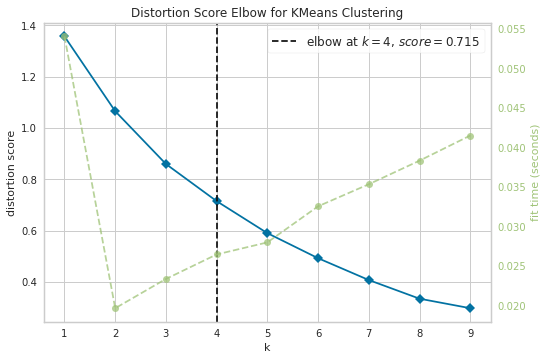

In [28]:
from sklearn.cluster import KMeans
! pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer

Notts_clustering = Notts_grouped.drop('Postal code',1)

# Clustering model and visualizer
model=KMeans()
visualizer=KElbowVisualizer(model, k=(1,10))

visualizer.fit(Notts_clustering)
visualizer.poof()

In [29]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Notts_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:29]

array([2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 0, 1, 3, 2, 1, 2, 2, 1, 1, 2,
       1, 2, 2, 1, 2, 2, 2], dtype=int32)

In [30]:
# add clustering labels
Notts_venues_sorted.insert(0, 'Cluster', kmeans.labels_)
Notts_venues_sorted['Cluster']= Notts_venues_sorted['Cluster'].astype(int)
Notts_venues_sorted.rename(columns={'Postal code': 'Postcode district'}, inplace=True, errors='raise')
Notts_merged=df.join(Notts_venues_sorted.set_index('Postcode district'), on='Postcode district')

Notts_merged

,Postcode district,Post town,Coverage,Local authority area(s),Full address,Longitude,Latitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,NG1,NOTTINGHAM,Nottingham city centre,Nottingham,"NG1,NOTTINGHAM",-1.141801,52.955513,2,Pub,Bar,Coffee Shop,Indian Restaurant,Café,Bookstore,Italian Restaurant,Movie Theater,Seafood Restaurant,Brewery
1,NG2,NOTTINGHAM,"Nottingham city centre, Colwick Park, Sneinton...","Nottingham, Rushcliffe","NG2,NOTTINGHAM",-1.165191,52.941864,2,Bar,Pub,Indian Restaurant,Coffee Shop,Café,Italian Restaurant,Bookstore,Park,Tapas Restaurant,Gastropub
2,NG3,NOTTINGHAM,"Carlton, Sneinton, St Ann's, Mapperley","Gedling, Nottingham","NG3,NOTTINGHAM",-1.151815,52.965092,2,Pub,Bar,Indian Restaurant,Café,Coffee Shop,Bookstore,Italian Restaurant,Seafood Restaurant,Movie Theater,Park
3,NG4,NOTTINGHAM,"Gedling Village, Netherfield, Carlton, Colwick",Gedling,"NG4,NOTTINGHAM",-1.101884,52.966431,2,Pub,Bar,Indian Restaurant,Coffee Shop,Café,Park,Bookstore,Italian Restaurant,Cocktail Bar,Burger Joint
4,NG5,NOTTINGHAM,"Sherwood, Arnold, Bestwood, Carrington, Top Va...","Nottingham, Gedling","NG5,NOTTINGHAM",-1.158969,52.989743,2,Pub,Park,Bar,Grocery Store,Indian Restaurant,Cocktail Bar,Café,Gym / Fitness Center,Gym,Concert Hall
5,NG6,NOTTINGHAM,"Bestwood Village, Bulwell, Old Basford","Nottingham, Gedling","NG6,NOTTINGHAM",-1.214203,53.005101,1,Pub,Supermarket,Grocery Store,Fast Food Restaurant,Hotel,Furniture / Home Store,Discount Store,Restaurant,Tram Station,Warehouse Store
6,NG7,NOTTINGHAM,"New Basford, Forest Fields, Hyson Green, Radfo...",Nottingham,"NG7,NOTTINGHAM",-1.168569,52.969543,2,Pub,Bar,Indian Restaurant,Coffee Shop,Café,Gym / Fitness Center,Italian Restaurant,Bookstore,Burger Joint,Seafood Restaurant
7,NG8,NOTTINGHAM,"Aspley, Wollaton, Whitemoor, Bilborough, Strelley","Nottingham, Broxtowe","NG8,NOTTINGHAM",-1.216109,52.952063,2,Pub,Coffee Shop,Gym / Fitness Center,Sandwich Place,Grocery Store,Bar,Café,Hotel,Pharmacy,Park
8,NG9,NOTTINGHAM,"Beeston, Stapleford, Lenton Abbey, Chilwell, T...","Broxtowe, Nottingham","NG9,NOTTINGHAM",-1.149646,52.953419,2,Pub,Bar,Coffee Shop,Indian Restaurant,Café,Bookstore,Cocktail Bar,Italian Restaurant,Movie Theater,Gastropub
9,NG10,NOTTINGHAM,"Long Eaton, Sawley, Sandiacre",Erewash,"NG10,NOTTINGHAM",-1.277511,52.900998,1,Pub,Grocery Store,Supermarket,Coffee Shop,Gym / Fitness Center,Hotel,Restaurant,Discount Store,Pharmacy,Bar


In [31]:
Notts_merged.dtypes

Postcode district           object
Post town                   object
Coverage                    object
Local authority area(s)     object
Full address                object
Longitude                  float64
Latitude                   float64
Cluster                      int64
1st Most Common Venue       object
2nd Most Common Venue       object
3rd Most Common Venue       object
4th Most Common Venue       object
5th Most Common Venue       object
6th Most Common Venue       object
7th Most Common Venue       object
8th Most Common Venue       object
9th Most Common Venue       object
10th Most Common Venue      object
dtype: object

In [32]:
Notts_merged['Cluster']= Notts_merged['Cluster'].astype(int)
Notts_merged.dtypes

Postcode district           object
Post town                   object
Coverage                    object
Local authority area(s)     object
Full address                object
Longitude                  float64
Latitude                   float64
Cluster                      int64
1st Most Common Venue       object
2nd Most Common Venue       object
3rd Most Common Venue       object
4th Most Common Venue       object
5th Most Common Venue       object
6th Most Common Venue       object
7th Most Common Venue       object
8th Most Common Venue       object
9th Most Common Venue       object
10th Most Common Venue      object
dtype: object

In [33]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=[52.950001, -1.150000], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Notts_merged['Latitude'], Notts_merged['Longitude'], Notts_merged['Postcode district'], Notts_merged['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_Notts)     

map_Notts

In [34]:
# Red cluster - Sports shop area
Notts_merged.loc[Notts_merged['Cluster'] == 0, Notts_merged.columns[[0] + list(range(5, Notts_merged.shape[1]))]]

,Postcode district,Longitude,Latitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,NG20,-1.148304,53.204385,0,Sporting Goods Shop,Pub,Bar,Insurance Office,Clothing Store,Department Store,Deli / Bodega,Dessert Shop,Cricket Ground,Creperie


In [35]:
# Purple cluster - Pubs and Grocery Stores area
Notts_merged.loc[Notts_merged['Cluster'] == 1, Notts_merged.columns[[0] + list(range(5, Notts_merged.shape[1]))]]

,Postcode district,Longitude,Latitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,NG6,-1.214203,53.005101,1,Pub,Supermarket,Grocery Store,Fast Food Restaurant,Hotel,Furniture / Home Store,Discount Store,Restaurant,Tram Station,Warehouse Store
9,NG10,-1.277511,52.900998,1,Pub,Grocery Store,Supermarket,Coffee Shop,Gym / Fitness Center,Hotel,Restaurant,Discount Store,Pharmacy,Bar
13,NG14,-1.058502,52.978257,1,Grocery Store,Pub,Supermarket,Coffee Shop,Train Station,English Restaurant,Clothing Store,Pharmacy,Pet Store,Park
14,NG15,-1.188919,53.021228,1,Pub,Grocery Store,Supermarket,Hotel,Fast Food Restaurant,Warehouse Store,Tram Station,Furniture / Home Store,Italian Restaurant,Discount Store
15,NG16,-1.331449,53.025449,1,Grocery Store,Pub,Fast Food Restaurant,Supermarket,Park,Discount Store,Indian Restaurant,Bar,Garden Center,Deli / Bodega
17,NG17,-1.269579,53.123772,1,Grocery Store,Pub,Clothing Store,Supermarket,Gastropub,Coffee Shop,Fish & Chips Shop,Discount Store,Sandwich Place,Pizza Place
18,NG18,-1.101884,53.144768,1,Grocery Store,Burger Joint,Gastropub,Resort,Coffee Shop,Creperie,Recreation Center,Pub,Pool,Pizza Place
21,NG21,-1.132632,53.123200,1,Pub,Grocery Store,Park,Bar,Gastropub,Restaurant,Supermarket,Gas Station,Gym / Fitness Center,Playground
24,NG24,-0.803577,53.075369,1,Pub,Grocery Store,Coffee Shop,Supermarket,Clothing Store,Hotel,Pharmacy,Pizza Place,Electronics Store,Discount Store
26,NG31,-0.642605,52.912789,1,Grocery Store,Clothing Store,Pub,Pizza Place,Discount Store,Supermarket,Hotel,Furniture / Home Store,Pharmacy,Coffee Shop


In [36]:
# Turquoise cluster - Pubs, bars and restaurant area
Notts_merged.loc[Notts_merged['Cluster'] == 2, Notts_merged.columns[[0] + list(range(5, Notts_merged.shape[1]))]]

,Postcode district,Longitude,Latitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,NG1,-1.141801,52.955513,2,Pub,Bar,Coffee Shop,Indian Restaurant,Café,Bookstore,Italian Restaurant,Movie Theater,Seafood Restaurant,Brewery
1,NG2,-1.165191,52.941864,2,Bar,Pub,Indian Restaurant,Coffee Shop,Café,Italian Restaurant,Bookstore,Park,Tapas Restaurant,Gastropub
2,NG3,-1.151815,52.965092,2,Pub,Bar,Indian Restaurant,Café,Coffee Shop,Bookstore,Italian Restaurant,Seafood Restaurant,Movie Theater,Park
3,NG4,-1.101884,52.966431,2,Pub,Bar,Indian Restaurant,Coffee Shop,Café,Park,Bookstore,Italian Restaurant,Cocktail Bar,Burger Joint
4,NG5,-1.158969,52.989743,2,Pub,Park,Bar,Grocery Store,Indian Restaurant,Cocktail Bar,Café,Gym / Fitness Center,Gym,Concert Hall
6,NG7,-1.168569,52.969543,2,Pub,Bar,Indian Restaurant,Coffee Shop,Café,Gym / Fitness Center,Italian Restaurant,Bookstore,Burger Joint,Seafood Restaurant
7,NG8,-1.216109,52.952063,2,Pub,Coffee Shop,Gym / Fitness Center,Sandwich Place,Grocery Store,Bar,Café,Hotel,Pharmacy,Park
8,NG9,-1.149646,52.953419,2,Pub,Bar,Coffee Shop,Indian Restaurant,Café,Bookstore,Cocktail Bar,Italian Restaurant,Movie Theater,Gastropub
10,NG11,-1.149646,52.953419,2,Pub,Bar,Coffee Shop,Indian Restaurant,Café,Bookstore,Cocktail Bar,Italian Restaurant,Movie Theater,Gastropub
11,NG12,-1.149646,52.953419,2,Pub,Bar,Coffee Shop,Indian Restaurant,Café,Bookstore,Cocktail Bar,Italian Restaurant,Movie Theater,Gastropub


In [37]:
# Green cluster - Brewery and Ice cream shop area
Notts_merged.loc[Notts_merged['Cluster'] == 3, Notts_merged.columns[[0] + list(range(5, Notts_merged.shape[1]))]]

,Postcode district,Longitude,Latitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,NG22,-0.939795,53.118346,3,Brewery,Ice Cream Shop,Gastropub,Farmers Market,Zoo,Flea Market,Fish & Chips Shop,Fast Food Restaurant,English Restaurant,Electronics Store


## Results and Discussion

This analysis has done the following:

* Taken the Nottingham postal code data and found cinema locations within a 50,000m radius of the Nottinghamshire county central latitude and longitude coordinates.
* Both the postal codes and the nearby existing cinema venues have been plotted on a map of the region.
* The postcode areas have been explored to examine nearby venues and the top 10 venues in a 4,000m radius from the postcode coordinates have been found.
* The postcode areas have been compared and clustered using the kmeans algorithm method.
* The resulting clusters have been plotted as an overlay onto the cinema and postcode map.
* The resulting visual provides a good indication of what type of clusters already have a cinema and therefore which areas may be a good location for a new cinema to be built.

The results above are limited in that they have used only nearby cinemas and clustering of similar Neighbourhoods to determine a suitable location.  As can be seen from the results of the clustering, the Neighbourhood clusters in Nottinghamshire are fairly similar - they all contain a lot of pubs, although I have tried to name them according to their most popular venues.
There is good coverage with regards to existing cinema venues, with the largest concentration of venues being in the centre of Nottingham as one may expect.  
Grantham (NG31 and NG32), Long Eaton (NG10) and Newark (NG24) are all found in the purple clusters which has pubs and grocery shops as being the most popular venues. Sleaford (NG34) falls into the purple cluster but does not have a nearby cinema. 

 

## Conclusion

This conclusion is limited by the data presented above only.  In reality, other information would be considered, such as demographic information (population density; wealth of the surrounding areas); land/property price; financial viability of existing cinemas.  
Two types of clusters already have cinemas.  These are the purple and the turquoise clusters.  
Based on the data presented within this analysis, the best location for a new cinema to be built is **Sleaford (NG34)**.  There are 2 main reasons for this conclusion: firstly, it is a postal code that falles within the same clusters as those postal codes with existing cinemas, and secondly, it does not already have another cinema close by. 